# Gestión Moderna de Portafolio
### Autores Bernardo León y Carlos Zapata
### (C) Copyright 2023

## Capitulo 13: Optimización Robusta de Portafolios


In [1]:
#Librerías usadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import stats
%pip install --quiet yfinance
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 750.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 797.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 3.6 MB/s eta 0:00:00


### Ejemplo 13.1

In [ ]:
# Información histórica dentro de muetsra (In-sample) para las acciones
fechai = "2015-12-01"
fechaf = "2020-12-31"
periodicidad = "1Mo"
activos = ["ADBE","MCD","MSCI","MSFT","NEE","PG","RSG","WMT"]
precios = yf.download(activos,start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
cov = retornos.cov()
sigma = retornos.std()

[*********************100%***********************]  8 of 8 completed


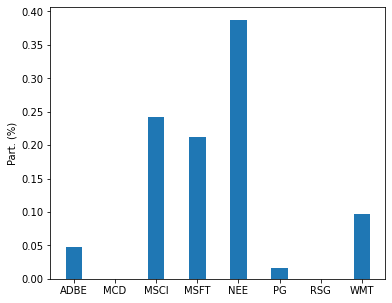

In [ ]:
# PT de Sharpe
rf = 0.0
r = mu -rf 
n = len(mu)
# PT de Sharpe
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
objective = cp.Minimize(risk)
constraints = [w @ r == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wpt = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpt, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

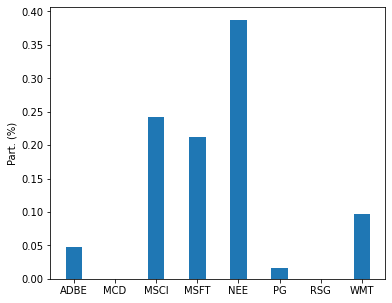

In [ ]:
# PT de Sharpe
rf = 0.0
r = mu -rf 
n = len(mu)

# PT de Sharpe
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
objective = cp.Minimize(risk)
constraints = [w @ r == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wpt = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpt, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

### Portafolios Robustos

#### Incertidumbre de Intervalo

In [ ]:
# Calculo delta (distribución normal)
from scipy.stats import norm
t = len(retornos)
alpha = 0.05
znorm = norm.ppf((1-alpha/2))
delta = znorm*sigma/np.sqrt(t)

# Calculo lambda
rpt = wpt @ mu
sigmapt = np.sqrt(wpt.T @ cov @ wpt)
lambda_coef = (rpt-rf)/sigmapt**2

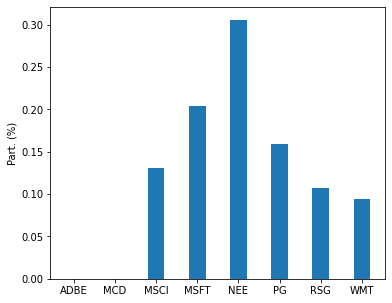

In [ ]:
# PRMVi
unos = np.repeat(1,n)
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
objective = cp.Maximize(w @ mu - w * delta - lambda_coef*risk)
constraints = [w @ unos == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wprmvi = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wprmvi, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

#### Incertidumbre Elipsoidal

In [ ]:
# Calculo delta (distribución Chi-cuadrado)
from scipy.stats import chi2
alpha = 0.05
delta2 = np.sqrt(chi2.ppf(alpha, n))
round(delta2,4)

1.6531

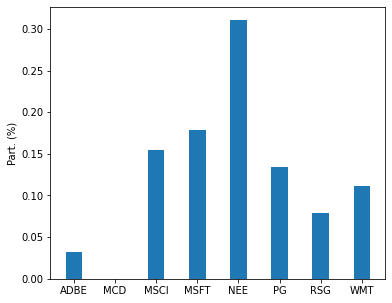

In [ ]:
# PRMVe
unos = np.repeat(1,n)
w = cp.Variable(n)
S12 = np.linalg.cholesky(cov)
risk = cp.quad_form(w, cov)
objective = cp.Maximize(w @ mu - lambda_coef*risk - delta2 * np.linalg.norm(S12) )
constraints = [w @ unos == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wprmve = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wprmve, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()